<a href="https://colab.research.google.com/github/fazulrehmanm/VIT/blob/main/VIT_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [2]:


torch.__version__

'2.6.0+cu124'

In [29]:

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))]
    # Help model converage faster
    # Matches pretraining conditions
    # Avoids bias in learning
    # Keeps numerical stablility
)

In [30]:

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])


In [31]:
train_dataset = datasets.CIFAR10(
    root="data", # where to download the data
    train=True,
    download=True, # do you want to download the data yes/no
    transform=transform_train
)

In [32]:
test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform_test
)

In [33]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [34]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [60]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 448

# Convert our datasets into iterables (batches - batchify our data)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=2)

cat


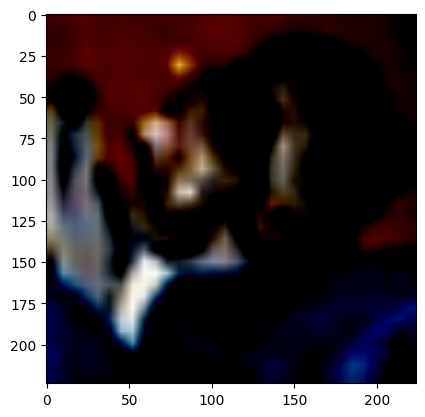

In [61]:
image, label = test_dataset[0]
print(test_dataset.classes[label])
plt.imshow(image.permute(1,2,0))

In [62]:
class_names = train_dataset.classes

In [63]:
def plot_img(img, label):
    img = img / 2 + 0.5 # unnormlizing the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.title(class_names[label])

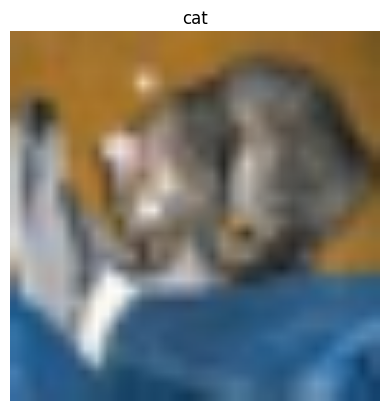

In [64]:
plot_img(image, label);

In [65]:

train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([448, 3, 224, 224]), torch.Size([448]))

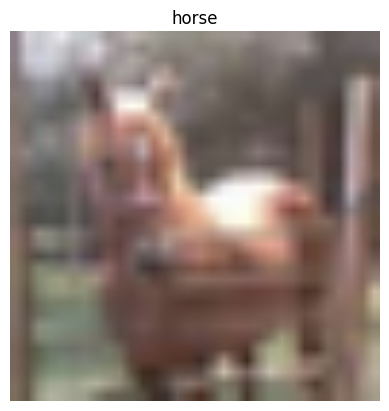

In [66]:

# Visualize one sample from a batch
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plot_img(img, label)

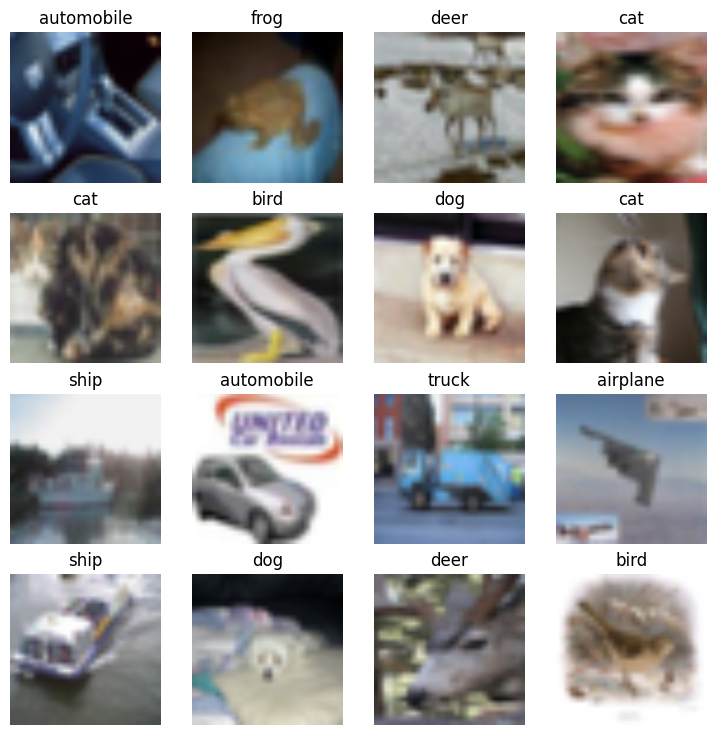

In [67]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    fig.add_subplot(rows, cols, i)
    img, label = train_dataset[random_idx]
    plot_img(img, label)

In [68]:
len(class_names)

10

In [69]:
model = timm.create_model("vit_tiny_patch16_224",
                          pretrained=True,
                          num_classes=len(class_names))

In [46]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [47]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [70]:
loss_fn = nn.CrossEntropyLoss() # Measure how wrong our model is
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=3e-4) # learning rate is an important hyperparmeter

In [71]:
loss_fn

CrossEntropyLoss()

In [72]:
def train_model(model, loader, criterion, optimizer, epochs=10):
    model.train() # Set the mode of the model to training
    model.to("cuda") # Move the model to the target device
    for epoch in range(epochs):
        running_loss = 0
        count=0
        for inputs, labels in loader:
            #1. We have to move the inputs and lable to the target deivce
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            optimizer.zero_grad()
            # 2. Forward pass
            outputs = model(inputs)
            # 3. Calculate the loss (per batch)
            loss = loss_fn(outputs, labels)
            # 4. Perform backpropgation
            loss.backward()
            # 5. Perform gradient descent
            optimizer.step() # update the weight and biases to better represent the data
            running_loss += loss.item() # Accumualte the loss
            print("running_loss: ",running_loss)
            print("iteration: ",count)
            count += 1
        print(f"Epoch: {epoch+1}, Loss: {running_loss / len(loader):.4f}")


In [73]:
train_model(model, train_loader, loss_fn, optimizer)

running_loss:  2.8105008602142334
iteration:  0
running_loss:  4.645808100700378
iteration:  1
running_loss:  5.850201487541199
iteration:  2
running_loss:  6.6573328375816345
iteration:  3
running_loss:  7.37965726852417
iteration:  4
running_loss:  7.863574773073196
iteration:  5
running_loss:  8.303070604801178
iteration:  6
running_loss:  8.741110116243362
iteration:  7
running_loss:  9.193580090999603
iteration:  8
running_loss:  9.691448956727982
iteration:  9
running_loss:  10.093123614788055
iteration:  10
running_loss:  10.423420935869217
iteration:  11
running_loss:  10.730696052312851
iteration:  12
running_loss:  11.07756581902504
iteration:  13
running_loss:  11.347882091999054
iteration:  14
running_loss:  11.654332250356674
iteration:  15
running_loss:  11.891207158565521
iteration:  16
running_loss:  12.13624618947506
iteration:  17
running_loss:  12.377506405115128
iteration:  18
running_loss:  12.54920144379139
iteration:  19
running_loss:  12.84469710290432
iteration

KeyboardInterrupt: 

In [75]:
def evaluate_model(model, loader):
    model.eval() # set the mode of the model into evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        accuracy = 100 * correct / total
        print(f"Accuracy: {accuracy:.2f}%")
        return all_labels, all_preds

In [76]:
labels, preds = evaluate_model(model, test_loader)

Accuracy: 95.49%


In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=labels,
                      y_pred=preds)

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

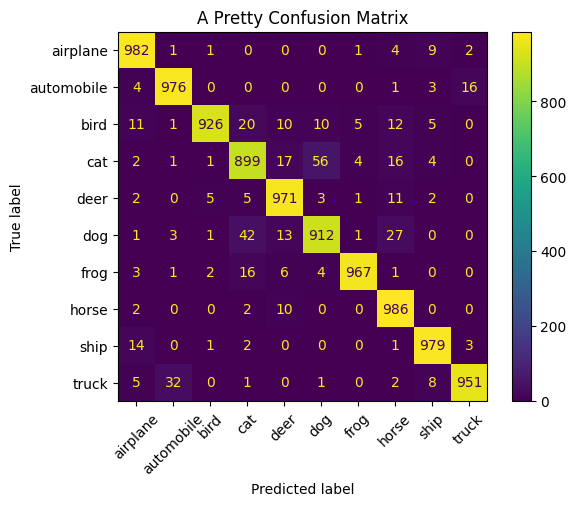

In [79]:

disp.plot(xticks_rotation=45, cmap="viridis")
plt.title("A Pretty Confusion Matrix")
plt.show()

In [80]:
import random
image.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [83]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
    model.eval()
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(9, 9))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = random.randint(0, len(dataset) - 1)
            img, true_label = dataset[idx]
            input_tensor = img.unsqueeze(dim=0).to("cuda")
            with torch.inference_mode():
                output = model(input_tensor)
                _, predicted = torch.max(output.data, 1)
            img = img / 2 + 0.5
            npimg = img.cpu().numpy()
            axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
            color = classes[true_label] == classes[predicted.item()]
            if color:
                c = "g"
            else:
                c = "r"
            axes[i, j].set_title(f"Truth: {classes[true_label]}\n, Predicted: {classes[predicted.item()]}", fontsize=10, c=c)
            axes[i, j].axis("off")
    plt.tight_layout()
    plt.show()

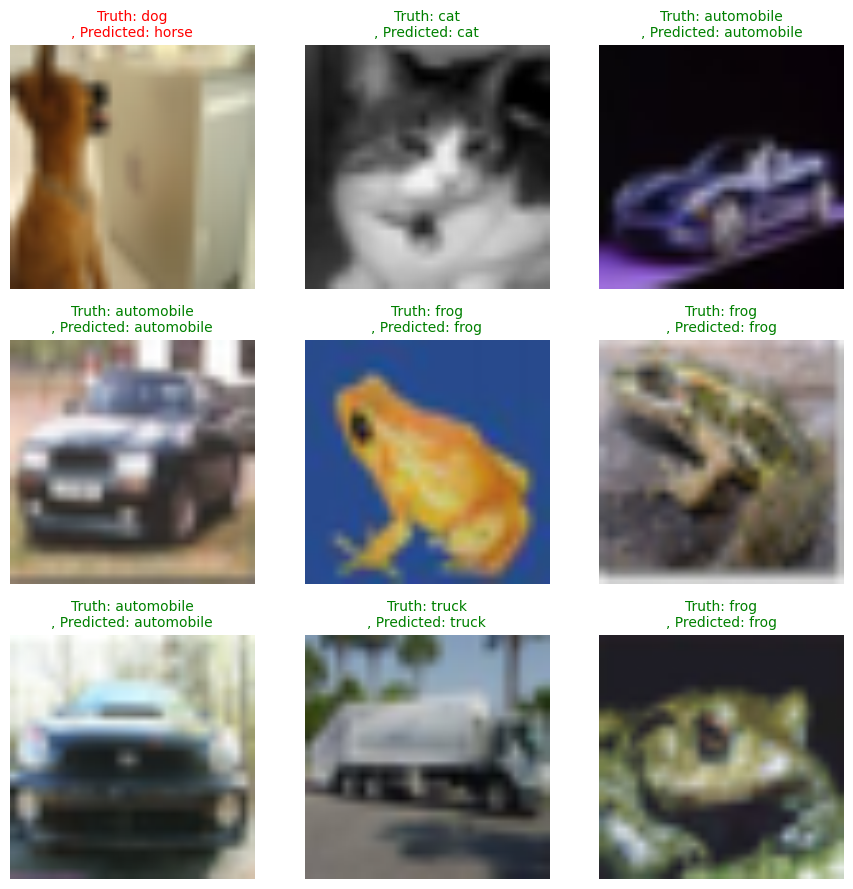

In [88]:
predict_and_plot_grid(model,
                      test_dataset,
                      train_dataset.classes)

In [89]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [90]:
from captum.attr import LayerGradCam

In [157]:
target_layer = model.patch_embed.proj

In [172]:
gradcam=LayerGradCam(model,target_layer)
#Compute attributions
idx = random.randint(0, len(test_dataset) - 1)
print("idx: ",idx)
img, true_label = test_dataset[idx]
input_tensor = img.unsqueeze(dim=0).to("cuda")
with torch.inference_mode():
    output = model(input_tensor)
    _, predicted = torch.max(output.data, 1)
attributions = gradcam.attribute(input_tensor,target=predicted)

idx:  3967


In [168]:
from PIL import Image

In [169]:
attributions.shape

torch.Size([1, 1, 14, 14])

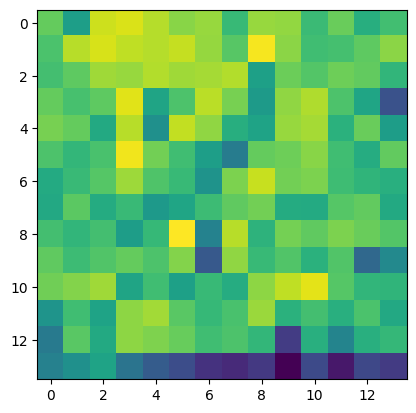

In [173]:
plt.imshow(attributions[0][0].cpu().detach().numpy())

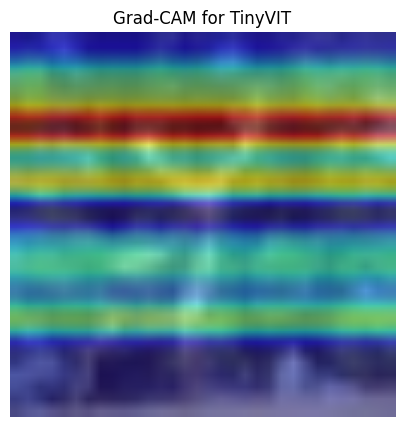

In [175]:
cam= attributions.squeeze().mean(dim=0).cpu().detach().numpy()
cam= np.maximum(cam,0)
cam = (cam-cam.min()) / (cam.max()-cam.min()+1e-8)
cam = np.uint8(255*cam)
cam = Image.fromarray(cam).resize((224,224),resample=Image.BICUBIC)
cam = np.array(cam)

#overlay
original = np.array(img)*0.5 + 0.5
plt.figure (figsize=(10,5))
plt.imshow(original.transpose(1,2,0))
plt.imshow(cam,cmap='jet',alpha=0.5)
plt.title("Grad-CAM for TinyVIT")
plt.axis("off")
plt.show()